<a href="https://colab.research.google.com/github/namwootree/Basic_Skill/blob/main/Unsupervised%20Learning/%ED%95%B8%EC%A6%88%EC%98%A8%20%EB%B9%84%EC%A7%80%EB%8F%84%20%ED%95%99%EC%8A%B5/Ch_9_%EC%A4%80%EC%A7%80%EB%8F%84_%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 준지도 학습

* 지도 학습과 비지도 학습의 장점을 도두 가진다

* 레이블이 약간만 있어도 데이터 셋의 구조를 파악하고 레이블이 지정하지 않은 관측치에 레이블이 지정할 수 있다

# Setting

## Library

In [1]:
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

In [3]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [4]:
import lightgbm as lgb

In [5]:
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

# Load Data Set

## Googel Drive Mount

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Credit Card Data Set

In [7]:
path_credit_card = '/content/drive/MyDrive/머신러닝 엔지니어링/핸즈온 비지도 학습/data/creditcard.csv'

data = pd.read_csv(path_credit_card)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Preprocessing

## Split X / y

In [8]:
X = data.copy().drop(['Class','Time'],axis=1)
y = data['Class'].copy()

## Scalering

In [9]:
featuresToScale = X.columns
sX = StandardScaler(copy=True, with_mean=True, with_std=True)
X.loc[:,featuresToScale] = sX.fit_transform(X[featuresToScale])

## Split Train / Test Set

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=2022,
                                                    stratify=y)

## Remove Labeled Data Set

* 일부 레이블이 있는 데이터 셋을 어떻게 활용하는지 시뮬레이션하기 위해 사기 거래의 90%를 훈련 셋에서 제외

* 현실 세계에서 사기 발생률은 매우 낮다

In [11]:
toDrop = y_train[y_train==1].sample(frac=0.90, random_state=2022)
X_train.drop(labels=toDrop.index,inplace=True)
y_train.drop(labels=toDrop.index,inplace=True)

# Modeling

## 평가 함수 및 그래프 함수 정의

### 평가 함수

In [12]:
def anomalyScores(originalDF, reducedDF):

    loss = np.sum((np.array(originalDF) - np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    
    return loss

### 그래프 함수

In [13]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):

    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = precision_recall_curve(preds['trueLabel'], 
                                                           preds['anomalyScore'])
    
    average_precision = average_precision_score(preds['trueLabel'],
                                                preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], 
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

### 특정 재현율 임계점별 정밀도를 평가 함수

In [14]:
def precisionAnalysis(df, column, threshold):
    df.sort_values(by=column, ascending=False, inplace=True)
    threshold_value = threshold*df.trueLabel.sum()
    i = 0
    j = 0
    while i < threshold_value+1:
        if df.iloc[j]["trueLabel"]==1:
            i += 1
        j += 1
    return df, i/j

## KFold

In [15]:
k_fold = StratifiedKFold(n_splits=5,
                         shuffle=True,
                         random_state=2022)

## 지도 학습 모델

In [16]:
params_lightGB = {
    'task': 'train',
    'application':'binary',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0,
    'num_threads':16
}

In [19]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                        index=y_train.index,
                                        columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), y_train.ravel()):

    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)

    gbm = lgb.train(params_lightGB,
                    lgb_train,
                    num_boost_round=2000,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=200,
                    verbose_eval=100)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold, num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', loglossLightGBMGradientBoosting)

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's binary_logloss: 0.00348359
[200]	valid_0's binary_logloss: 0.00332539
[300]	valid_0's binary_logloss: 0.00323184
[400]	valid_0's binary_logloss: 0.00314083
[500]	valid_0's binary_logloss: 0.0030502
[600]	valid_0's binary_logloss: 0.00297133
[700]	valid_0's binary_logloss: 0.00288834
[800]	valid_0's binary_logloss: 0.00281122
[900]	valid_0's binary_logloss: 0.00275335
[1000]	valid_0's binary_logloss: 0.00269991
[1100]	valid_0's binary_logloss: 0.00264214
[1200]	valid_0's binary_logloss: 0.00258963
[1300]	valid_0's binary_logloss: 0.0025512
[1400]	valid_0's binary_logloss: 0.00253424
[1500]	valid_0's binary_logloss: 0.00252154
[1600]	valid_0's binary_logloss: 0.00251441
[1700]	valid_0's binary_logloss: 0.00251194
[1800]	valid_0's binary_logloss: 0.00250888
[1900]	valid_0's binary_logloss: 0.00250661
[2000]	valid_0's binary_logloss: 0.00250459
Did not meet early stopping. Best iteration is:
[1999]	valid_0's bin

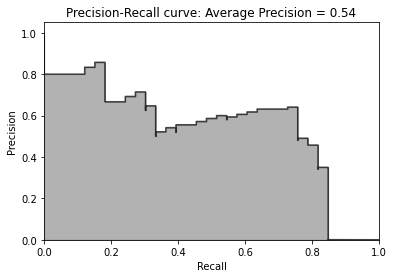

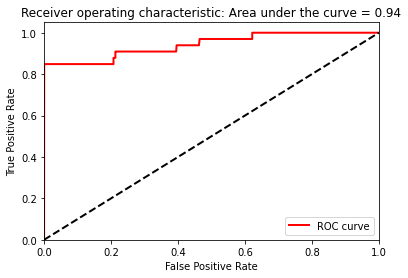

In [20]:
preds, average_precision = plotResults(y_train, predictionsBasedOnKFolds.loc[:,'prediction'], True)

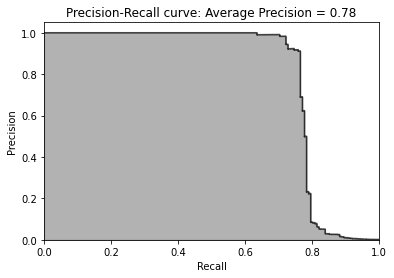

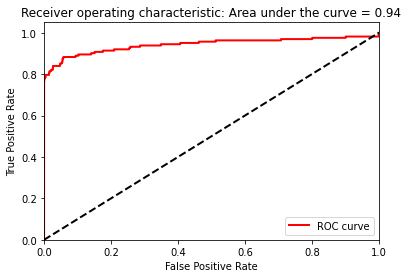

In [21]:
predictions = pd.Series(data=gbm.predict(X_test, num_iteration=gbm.best_iteration), index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [22]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print("Precision at 75% recall", precision)

Precision at 75% recall 0.917910447761194


## 비지도 학습

### 오버 샘플링

In [23]:
oversample_multiplier = 100

X_train_original = X_train.copy()
y_train_original = y_train.copy()
X_test_original = X_test.copy()
y_test_original = y_test.copy()

X_train_oversampled = X_train.copy()
y_train_oversampled = y_train.copy()
X_train_oversampled = X_train_oversampled.append([X_train_oversampled[y_train==1]]*oversample_multiplier, 
                                                 ignore_index=False)
y_train_oversampled = y_train_oversampled.append([y_train_oversampled[y_train==1]]*oversample_multiplier,
                                                 ignore_index=False)

X_train = X_train_oversampled.copy()
y_train = y_train_oversampled.copy()

### 모델 생성

In [24]:
model = Sequential()

model.add(Dense(units=40, activation='linear',
                activity_regularizer=regularizers.l1(10e-5),
                input_dim=29,name='hidden_layer'))

model.add(Dropout(0.02))

model.add(Dense(units=29, activation='linear'))

### 모델 컴파일

In [25]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

### 모델 학습

In [26]:
num_epochs = 5
batch_size = 32

history = model.fit(x=X_train, y=X_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.20,
                    verbose=1)

Epoch 1/5
4846/4846 [==============================] - 19s 4ms/step - loss: 0.0703 - accuracy: 0.8672 - val_loss: 0.0206 - val_accuracy: 0.9679
Epoch 2/5
4846/4846 [==============================] - 17s 3ms/step - loss: 0.0185 - accuracy: 0.9253 - val_loss: 0.0440 - val_accuracy: 0.9823
Epoch 3/5
4846/4846 [==============================] - 12s 2ms/step - loss: 0.0169 - accuracy: 0.9267 - val_loss: 0.0386 - val_accuracy: 0.9766
Epoch 4/5
4846/4846 [==============================] - 11s 2ms/step - loss: 0.0174 - accuracy: 0.9267 - val_loss: 0.0385 - val_accuracy: 0.9624
Epoch 5/5
4846/4846 [==============================] - 10s 2ms/step - loss: 0.0173 - accuracy: 0.9272 - val_loss: 0.0173 - val_accuracy: 0.9762


5954/5954 [==============================] - 7s 1ms/step


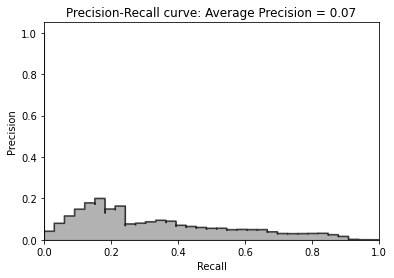

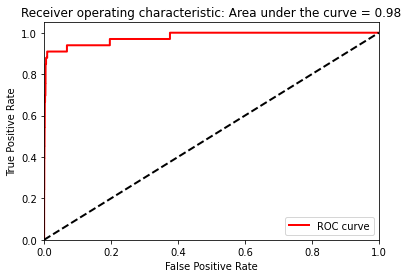

In [27]:
predictionsTrain = model.predict(X_train_original, verbose=1)
anomalyScoresAETrain = anomalyScores(X_train_original, predictionsTrain)
preds, average_precision = plotResults(y_train_original, anomalyScoresAETrain, True)

2938/2938 [==============================] - 5s 2ms/step


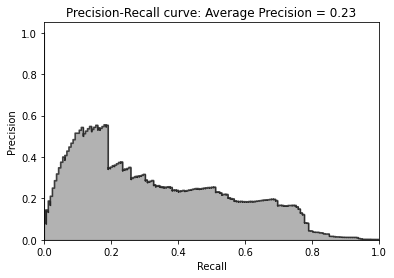

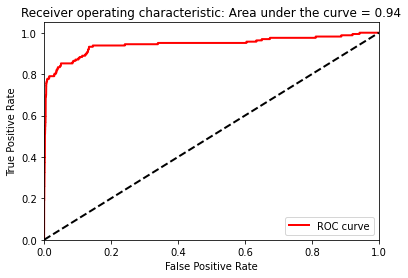

In [28]:
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds, average_precision = plotResults(y_test, anomalyScoresAE, True)

## 준지도 학습

In [33]:
layer_name = 'hidden_layer'

intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
intermediate_output_train = intermediate_layer_model.predict(X_train_original)
intermediate_output_test = intermediate_layer_model.predict(X_test_original)

2938/2938 [==============================] - 3s 1ms/step


In [34]:
intermediate_output_trainDF = pd.DataFrame(data=intermediate_output_train,index=X_train_original.index)
intermediate_output_testDF = pd.DataFrame(data=intermediate_output_test,index=X_test_original.index)

In [35]:
X_train = X_train_original.merge(intermediate_output_trainDF, left_index=True,right_index=True)
X_test = X_test_original.merge(intermediate_output_testDF, left_index=True,right_index=True)
y_train = y_train_original.copy()

In [37]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                        index=y_train.index,
                                        columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), y_train.ravel()):

    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB,
                    lgb_train,
                    num_boost_round=5000,
                    valid_sets=lgb_eval, 
                    early_stopping_rounds=200,
                    verbose_eval=200)
    
    loglossTraining = log_loss(y_train_fold, 
                                gbm.predict(X_train_fold,
                                num_iteration=gbm.best_iteration))
    
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', loglossLightGBMGradientBoosting)

Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.00105886
[400]	valid_0's binary_logloss: 0.000954942
[600]	valid_0's binary_logloss: 0.000920697
[800]	valid_0's binary_logloss: 0.000831685
[1000]	valid_0's binary_logloss: 0.000762906
[1200]	valid_0's binary_logloss: 0.000725082
[1400]	valid_0's binary_logloss: 0.000718955
[1600]	valid_0's binary_logloss: 0.000714497
[1800]	valid_0's binary_logloss: 0.000716232
Early stopping, best iteration is:
[1647]	valid_0's binary_logloss: 0.000713984
Training Log Loss:  1.9237714617980228e-08
CV Log Loss:  0.0007139843274720846
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.00541523
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.00109891
Training Log Loss:  0.002255401458952048
CV Log Loss:  0.0010989106778324725
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.00128406
[400]	valid_0

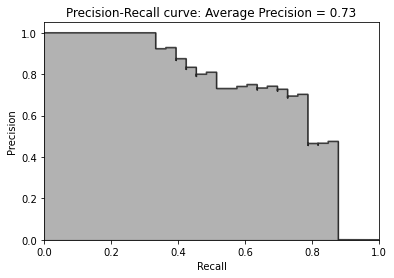

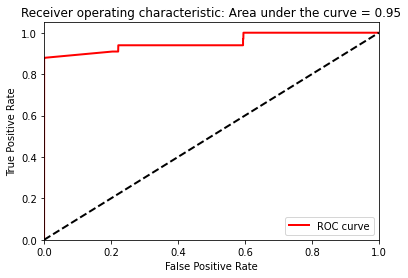

In [38]:
preds, average_precision = plotResults(y_train, predictionsBasedOnKFolds.loc[:,'prediction'], True)

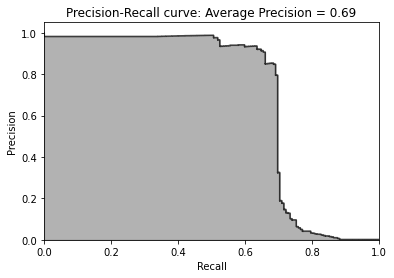

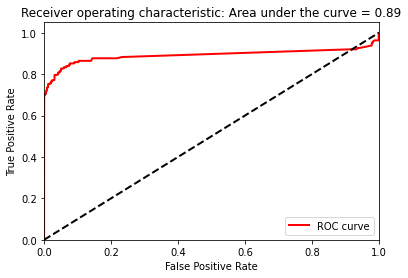

In [39]:
predictions = pd.Series(data=gbm.predict(X_test, 
                                         num_iteration=gbm.best_iteration),index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [40]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(precision)

0.06392931392931393


In [41]:
featuresImportance = pd.DataFrame(data=list(gbm.feature_importance()), 
                                  index=X_train.columns,columns=['featImportance'])
featuresImportance = featuresImportance/featuresImportance.sum()
featuresImportance.sort_values(by='featImportance', ascending=False,inplace=True)
featuresImportance

,featImportance
V27,0.090724
13,0.055386
16,0.053007
V13,0.052667
30,0.050629
...,...
33,0.000000
12,0.000000
V5,0.000000
9,0.000000
